In [1]:
!nvidia-smi

Thu Mar 14 13:46:06 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.94       Driver Version: 470.94       CUDA Version: 12.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:65:00.0 Off |                  Off |
| 30%   30C    P8    12W / 230W |    327MiB / 24256MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Run this once
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# project_dir = "/codespace/braintypicality"
# sys.path.append(project_dir)

In [3]:
import skimage
import glob
import math
import torch
import ants
import antspynet
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from matplotlib import ticker
import matplotlib as mpl
import matplotlib.colors as mcolors


from functools import partial
from scipy.ndimage import median_filter
import skimage.filters as skf
from scipy.stats import percentileofscore

[1710423968.508561] [fa79a04240ba:39596:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device


2024-03-14 13:46:11.595085: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 13:46:11.597415: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-14 13:46:11.632163: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from sade.configs.flows import ve_flow_config as configs
from sade.datasets.loaders import get_image_files_list, get_val_transform, get_lesion_transform

config = configs.get_config()
config.msma.denoise=False
config.msma.schedule = "geometric"
config.model.learnable_embedding=True
dataset_dir = config.data.dir_path
splits_dir = config.data.splits_dir
transforms_dir = f"/DATA/Users/amahmood/braintyp/spacing_{int(config.data.spacing_pix_dim)}"
workdir = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable"
CACHE_DIR = "/ASD/ahsan_projects/braintypicality/dataset/template_cache/"
unscale = lambda x: (x+1)/2
img_loader = get_val_transform(config)

procd_ref_img_path = f"{CACHE_DIR}/cropped_niral_mni.nii.gz"
ref_img_tensor = img_loader({"image": procd_ref_img_path})["image"].numpy()
ref_img_post_transform = unscale(ants.from_numpy(ref_img_tensor[0]))

In [5]:
# @jit(nopython=True)
def count(x):
    return np.count_nonzero(x, axis=0)

# @jit(nopython=True)
def vec_pscore(score, reference_scores):
    """
    Computes the percentile of a given tensor x at each position with respect to a reference tensor
    Args:
        x: Tensor of shape (b, h, w, d)
        reference_scores: Tensor of shape (b, h, w, d)
    Returns:
        percentiles: Tensor of shape (b, h, w, d)
    """

    n = reference_scores.shape[0]
    
    # Prepare broadcasting
    reference_scores = reference_scores[:, None, ...]

    left = count(reference_scores < score)
    right = count(reference_scores <= score)
    plus1 = left < right
    perct = (left + right + plus1) * (50.0 / n)
    return perct

def torch_pscore(score, reference_scores):
    """
    Computes the percentile of a given tensor x at each position with respect to a reference tensor
    Args:
        x: Tensor of shape (b, h, w, d)
        reference_scores: Tensor of shape (b, h, w, d)
    Returns:
        percentiles: Tensor of shape (b, h, w, d)
    """
    
    score = torch.from_numpy(score).cuda()
    
    n = reference_scores.shape[0]
    
    # Prepare broadcasting
    reference_scores = reference_scores[:, None, ...]

    left = torch.count_nonzero(reference_scores < score, dim=0)
    right = torch.count_nonzero(reference_scores <= score, dim=0)
    plus1 = left < right
    perct = (left + right + plus1) * (50.0 / n)
    
    return perct.cpu().numpy()

In [6]:
def register_to_mni(x:np.ndarray, fname: str):
    x = ants.from_numpy(x)
    sampleid = os.path.basename(fname).split(".nii.gz")[0]
    transform_mat = f"{transforms_dir}/{sampleid}Composite.h5"
    return ants.apply_transforms(
        fixed=ref_img_post_transform, interpolator="linear", verbose=False,
        moving=x, transformlist=transform_mat
    ).numpy()

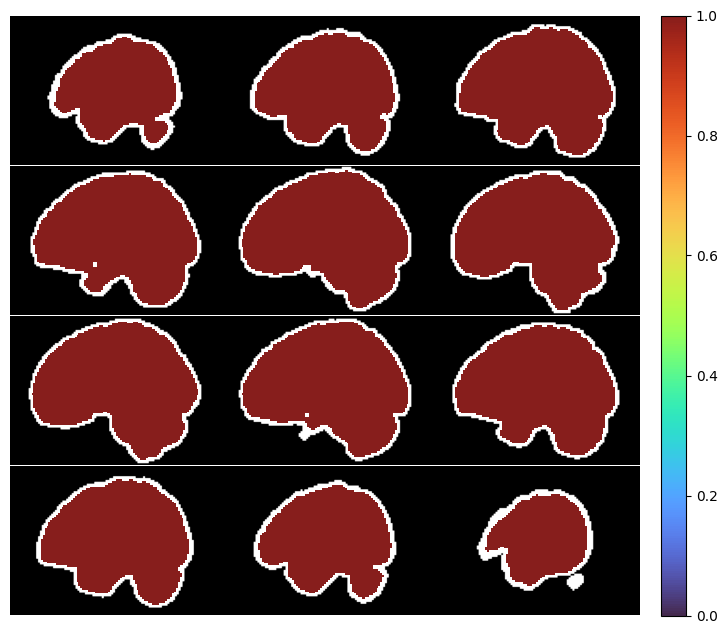

In [7]:
ref_mask = (ref_img_tensor > 0).sum(0) > 0
ref_mask = ants.from_numpy(ref_mask*1.0)
ref_mask_dilated = ants.morphology(ref_mask, operation='dilate', radius=1, mtype='binary', shape='ball')
ref_mask_dilated.plot(overlay=ref_mask, cbar=True)

In [8]:
# flow_path = '/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/flow/psz3-globalpsz17-nb20-lr0.0003-bs32-np1024-kimg200_nb20_long/eval/ckpt_6040/'
flow_path = '/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/flow/psz3-globalpsz17-nb20-lr0.0003-bs32-np1024-kimg300_smin1e-2_smax0.8/eval/ckpt_9240/'
%ls -ailh $flow_path/

total 6.4G
21475109661 drwxr-xr-x. 2 amahmood root 4.0K Mar  6 20:50 ./
17181880790 drwxr-xr-x. 3 amahmood root   30 Mar  4 19:32 ../
21476111878 -rw-r--r--. 1 amahmood root 2.0G Mar  5 22:44 abcd-test_lesion_load_20-enhanced_results.npz
21476853442 -rw-r--r--. 1 amahmood root  14K Mar  5 23:23 abcd-test_lesion_load_20-enhanced_seg_eval.csv
21476853440 -rw-r--r--. 1 amahmood root 779K Mar  5 23:22 abcd-test_lesion_load_20-enhanced_segs.npz
21476853460 -rw-r--r--. 1 amahmood root 2.0G Mar  6 20:52 abcd-val_lesion_load_20_results.npz
21476853444 -rw-r--r--. 1 amahmood root 823M Mar  6 00:10 ibis-hr-inlier_ibis-ds-sa_results.npz
21476853450 -rw-r--r--. 1 amahmood root 903M Mar 11 18:34 ibis-inlier_ibis-asd_results.npz
21476853452 -rw-r--r--. 1 amahmood root 737M Mar 11 19:31 ibis-inlier_ibis-atypical_results.npz


In [9]:
%%time

experiment = config.eval.experiment

config.eval.experiment.inlier = "ibis-hr-inlier"
config.eval.experiment.ood = "ibis-ds-sa"
experiment_name = f"{experiment.inlier}_{experiment.ood}"

data = np.load(f"{flow_path}/{experiment_name}_results.npz", allow_pickle=True)
x_hr_inlier_scores = data["inliers"]
x_ds_scores = data["ood"]

CPU times: user 3.93 s, sys: 329 ms, total: 4.26 s
Wall time: 4.26 s


In [10]:
%%time
config.eval.experiment.inlier = "ibis-inlier"
config.eval.experiment.ood = "ibis-atypical"
experiment_name = f"{experiment.inlier}_{experiment.ood}"
data = np.load(f"{flow_path}/{experiment_name}_results.npz", allow_pickle=True)
x_inlier_scores = data["inliers"]
x_atypical_scores = data["ood"]

config.eval.experiment.ood = "ibis-asd"
experiment_name = f"{experiment.inlier}_{experiment.ood}"
data = np.load(f"{flow_path}/{experiment_name}_results.npz", allow_pickle=True)
x_asd_scores = data["ood"]

CPU times: user 5.34 s, sys: 544 ms, total: 5.88 s
Wall time: 5.89 s


In [11]:
x_inlier_scores.shape, x_hr_inlier_scores.shape, x_ds_scores.shape, x_atypical_scores.shape, x_asd_scores.shape

((82, 96, 112, 80),
 (106, 96, 112, 80),
 (28, 96, 112, 80),
 (38, 96, 112, 80),
 (65, 96, 112, 80))

In [12]:
config.eval.experiment.inlier = "abcd-val"
config.eval.experiment.ood = "lesion_load_20"
experiment_name = f"{experiment.inlier}_{experiment.ood}"
data = np.load(f"{flow_path}/{experiment_name}_results.npz", allow_pickle=True)
x_abcd_val_scores = data["inliers"]
x_lesion_scores = data["ood"]

config.eval.experiment.inlier = "abcd-test"
config.eval.experiment.ood = "lesion_load_20-enhanced"
experiment_name = f"{experiment.inlier}_{experiment.ood}"
data = np.load(f"{flow_path}/{experiment_name}_results.npz", allow_pickle=True)
x_abcd_test_scores = data["inliers"]

In [13]:
x_abcd_test_scores.shape, x_abcd_val_scores.shape

((165, 96, 112, 80), (165, 96, 112, 80))

In [14]:
abcd_train_files = get_image_files_list("abcd-train", dataset_dir, splits_dir)
abcd_val_files = get_image_files_list("abcd-val", dataset_dir, splits_dir)
abcd_test_files = get_image_files_list("abcd-test", dataset_dir, splits_dir)

ibis_inlier_files = get_image_files_list("ibis-inlier", dataset_dir, splits_dir)
ibis_ds_files = get_image_files_list("ibis-ds-sa", dataset_dir, splits_dir)
ibis_hr_files = get_image_files_list("ibis-hr-inlier", dataset_dir, splits_dir)
ibis_atyp_files = get_image_files_list("ibis-atypical", dataset_dir, splits_dir)
ibis_asd_files = get_image_files_list("ibis-asd", dataset_dir, splits_dir)

In [15]:
extract_id = lambda f: f.split("/")[-1].replace('.nii.gz', '')
extract_id(ibis_inlier_files[0]["image"])

'IBIS108372'

### Prealign or Post align ..?

## Align to MNI -> Compute Percentiles -> Brain Mask

In [16]:
%%time
x_abcd_val_scores_aligned = [register_to_mni(x, fname["image"]) for x, fname in zip(x_abcd_val_scores, abcd_val_files)]
x_abcd_test_scores_aligned = [register_to_mni(x, fname["image"]) for x, fname in zip(x_abcd_test_scores, abcd_test_files)]

CPU times: user 1min 49s, sys: 14 s, total: 2min 3s
Wall time: 1min 27s


In [17]:
%%time
x_inlier_scores_aligned = [register_to_mni(x, fname["image"]) for x, fname in zip(x_inlier_scores, ibis_inlier_files)]

CPU times: user 27.3 s, sys: 3.45 s, total: 30.7 s
Wall time: 21.7 s


In [18]:
%%time
x_hr_inlier_scores_aligned = [register_to_mni(x, fname["image"]) for x, fname in zip(x_hr_inlier_scores, ibis_hr_files)]

CPU times: user 35 s, sys: 4.35 s, total: 39.3 s
Wall time: 27.5 s


In [19]:
%%time
x_ds_scores_aligned = [register_to_mni(x, fname["image"]) for x, fname in zip(x_ds_scores, ibis_ds_files)]

CPU times: user 9.35 s, sys: 1.13 s, total: 10.5 s
Wall time: 7.41 s


In [20]:
%%time
x_atypical_scores_aligned = [register_to_mni(x, fname["image"]) for x, fname in zip(x_atypical_scores, ibis_atyp_files)]

CPU times: user 12.6 s, sys: 1.73 s, total: 14.3 s
Wall time: 10 s


In [21]:
%%time
x_asd_scores_aligned = [register_to_mni(x, fname["image"]) for x, fname in zip(x_asd_scores, ibis_asd_files)]

CPU times: user 21.6 s, sys: 2.67 s, total: 24.3 s
Wall time: 17.2 s


In [22]:
ref_mask_dilated

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (96, 112, 80)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [23]:
%%time
reference_scores = np.concatenate((x_abcd_val_scores_aligned, x_abcd_test_scores_aligned), axis=0) * ref_mask_dilated.numpy()
# reference_scores = skf.median(reference_scores, footprint=np.ones((1,3,3,3)), mode='constant')
reference_scores.shape

CPU times: user 1.65 s, sys: 861 ms, total: 2.51 s
Wall time: 2.51 s


(330, 96, 112, 80)

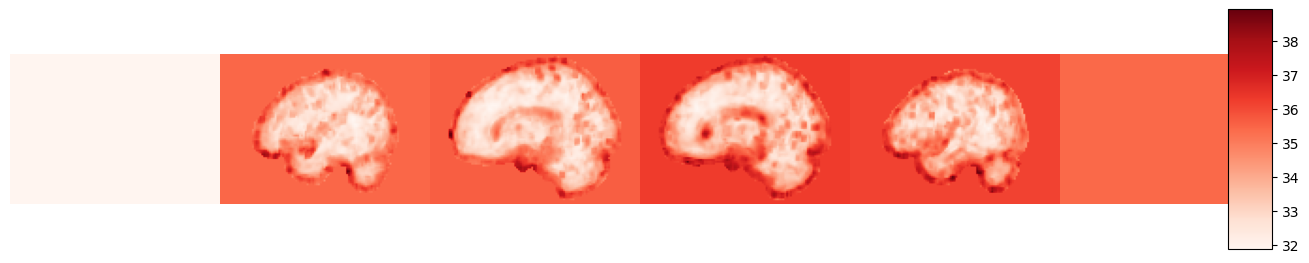

In [26]:
x = reference_scores[4].copy()
x = x - x.min()
x = ants.from_numpy(x)
x.plot(nslices=6, cmap="Reds", cbar=True)

In [27]:
%%time
reference_scores_avg = np.concatenate((x_abcd_val_scores_aligned, x_abcd_test_scores_aligned), axis=0)
reference_scores_avg = torch.from_numpy(reference_scores_avg).cuda()
reference_scores_avg = torch.nn.functional.avg_pool2d(reference_scores_avg, kernel_size=3, padding=1, stride=1)
reference_scores.shape

CPU times: user 1.02 s, sys: 724 ms, total: 1.75 s
Wall time: 1.76 s


(330, 96, 112, 80)

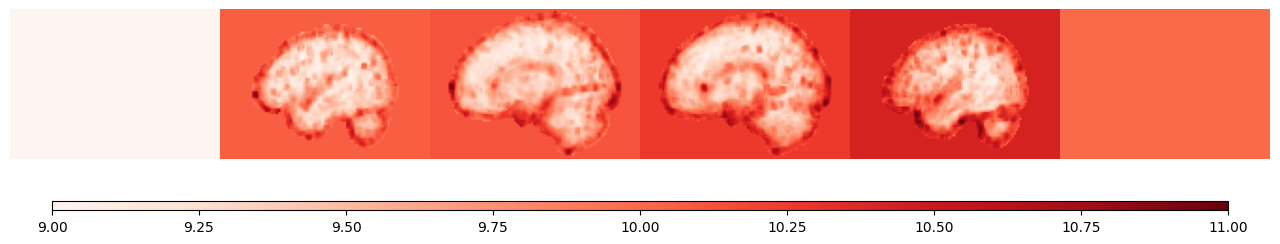

In [28]:
x_img = ants.from_numpy(reference_scores[0]) * ref_mask_dilated
ants.plot(x_img+10, nslices=6, cmap="Reds", cbar=True, cbar_vertical=False)

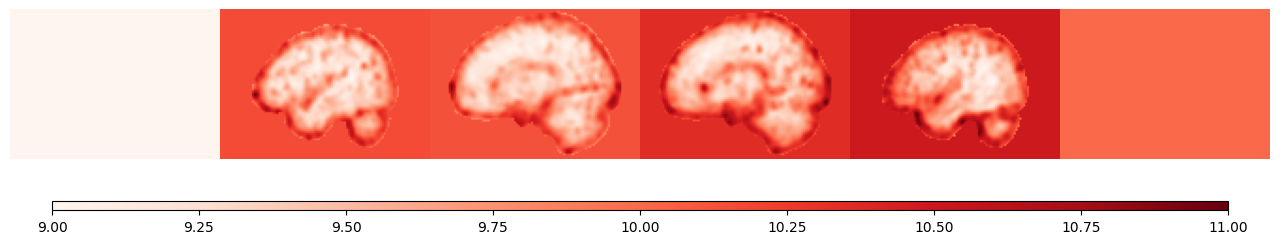

In [29]:
x_img = ants.from_numpy(reference_scores_avg[0].cpu().numpy()) * ref_mask_dilated
ants.plot(x_img+10, nslices=6, cmap="Reds", cbar=True, cbar_vertical=False)

In [30]:
reference_scores = torch.as_tensor(reference_scores).cuda()

In [31]:
x = np.stack(x_ds_scores_aligned[:2],)
x.shape

(2, 96, 112, 80)

In [32]:
%%time
ps = torch_pscore(x, reference_scores)
ps[0].shape

CPU times: user 42.1 ms, sys: 45.9 ms, total: 88 ms
Wall time: 98.2 ms


(96, 112, 80)

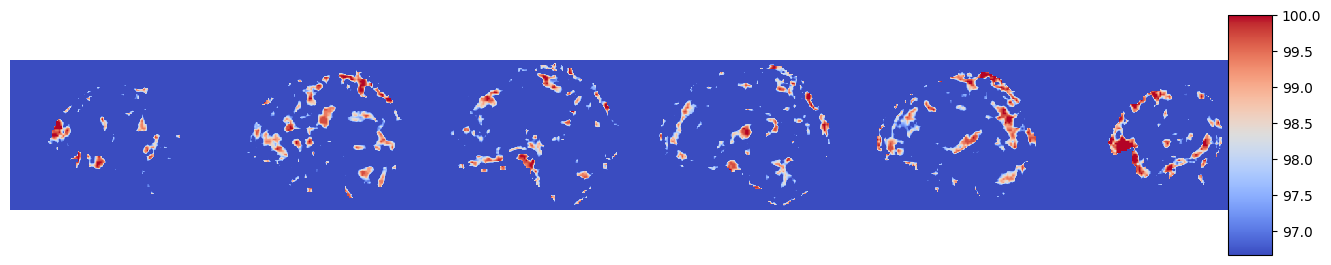

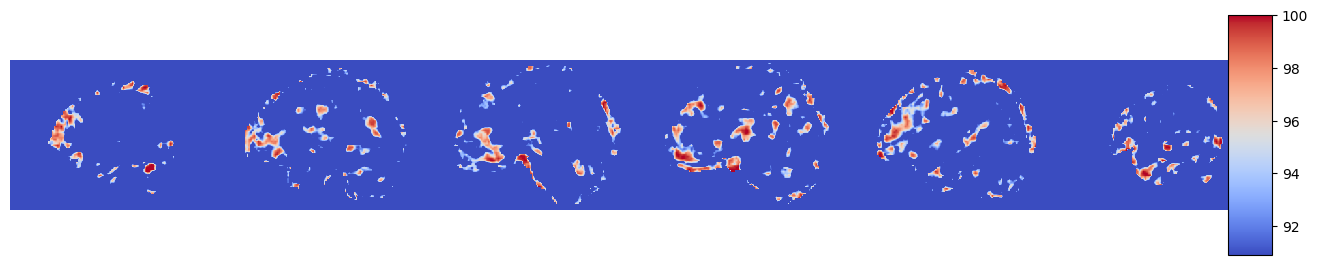

In [33]:
ants.plot((ants.from_numpy(ps[0]) * ref_mask_dilated), cmap="coolwarm", nslices=6, cbar=True, scale=(0.8, 1.0))
ants.plot((ants.from_numpy(ps[1]) * ref_mask_dilated), cmap="coolwarm", nslices=6, cbar=True, scale=(0.8, 1.0))

In [34]:
%%time
ps = torch_pscore(x, reference_scores_avg)
ps[0].shape

CPU times: user 9.26 ms, sys: 71.3 ms, total: 80.6 ms
Wall time: 79.1 ms


(96, 112, 80)

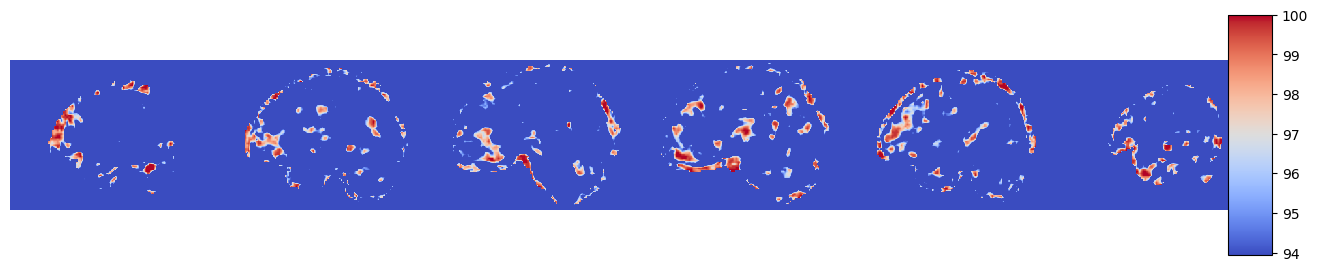

In [35]:
ants.plot((ants.from_numpy(ps[1]) * ref_mask_dilated), cmap="coolwarm", nslices=6, cbar=True, scale=(0.8, 1.0))

In [36]:
# ds_mean = torch.mean(x_ds_scores)

In [37]:
from collections import defaultdict

result_dict = defaultdict(list)

process_list = [
    ("Inlier", x_inlier_scores_aligned, ibis_inlier_files),
    ("HR-Inlier", x_hr_inlier_scores_aligned, ibis_hr_files),
    ("Atypical", x_atypical_scores_aligned, ibis_atyp_files),
    ("DS", x_ds_scores_aligned, ibis_ds_files),
    ("ASD", x_asd_scores_aligned, ibis_asd_files),
]

### Compute ROI Voxel-wise Percentiles

In [38]:
%%time
m = ref_mask_dilated.numpy()
for (name, scores, filenames) in process_list:
    for i, x in enumerate(scores):
        xpct = torch_pscore(x, reference_scores)[0]
        fname = filenames[i]["image"]
        xpct = xpct * m
        sid = extract_id(fname)
        result_dict[name].append((sid, xpct))

CPU times: user 2.42 s, sys: 8.19 s, total: 10.6 s
Wall time: 10.6 s


In [39]:
# x_masked = xpct * ref_mask_dilated.numpy()
# ants.from_numpy(x_masked).plot()

In [40]:
for ds, percentile_scores in result_dict.items():
    for sid, xpct in percentile_scores:
        np.save(f"{workdir}/eval/heatmaps_v2/percentiles/{sid}_pct_score.npy", xpct)

In [41]:
xpct = np.load(f"{workdir}/eval/heatmaps_v2/percentiles/{sid}_pct_score.npy")

In [42]:
xpct.shape

(96, 112, 80)

In [ ]:
# np.savez_compressed(f"{flow_path}/percentile_scores.npz",
#                     ds=x_ds_percentile_scores, inliers=x_inlier_percentile_scores,
#                     hr=x_hr_percentile_scores, atypical=x_atyp_percentile_scores,
#                     asd=x_asd_percentile_scores
#                    )

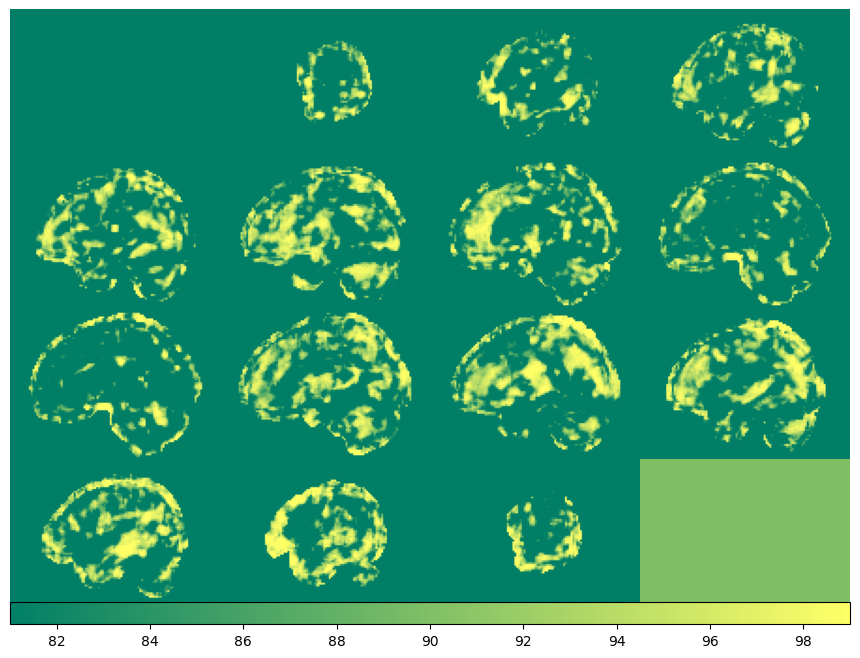

In [58]:
x = result_dict["DS"][0][1]
x = np.clip(x, 90, 100)
x_img = ants.from_numpy(x)
ants.plot(x_img, nslices=16, cmap="summer", cbar=True, cbar_vertical=False)

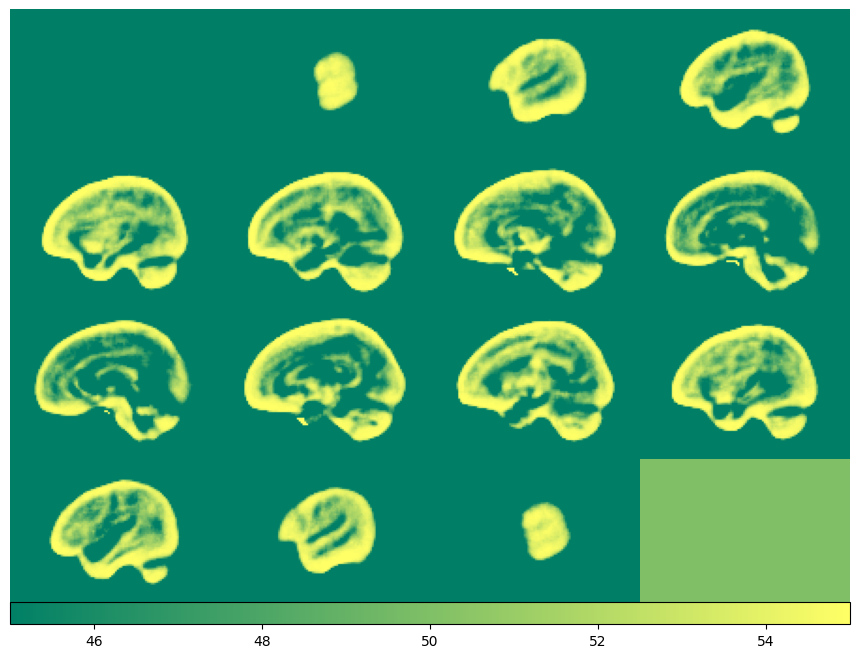

In [55]:
x = torch_pscore(x_inlier_scores.mean(0), reference_scores)[0]
x = np.clip(x, 50, 100)
x_img = ants.from_numpy(x)
ants.plot(x_img, nslices=16, cmap="summer", cbar=True, cbar_vertical=False)

In [ ]:
# %%time

# inlier_quantiles = ants.from_numpy(np.stack(
#     [np.quantile(x_inlier_percentiles_aligned, q=q, axis=0) for q in [0.25,0.5,0.75,0.99]],
#     axis=-1
# ))

# inlier_mean_var = ants.from_numpy(np.stack(
#     [np.mean(x_inlier_percentiles_aligned, axis=0), np.var(x_inlier_percentiles_aligned, axis=0)],
#     axis=-1
# ))

# ds_quantiles = ants.from_numpy(np.stack(
#     [np.quantile(x_ds_percentiles_aligned, q=q, axis=0) for q in [0.25,0.5,0.75,0.99]],
#     axis=-1
# ))

# ds_mean_var = ants.from_numpy(np.stack(
#     [np.mean(x_ds_percentiles_aligned, axis=0), np.var(x_ds_percentiles_aligned, axis=0)],
#     axis=-1
# ))

# inlier_mean_var.shape, ds_mean_var.shape

In [ ]:
# %%time
# from sade.datasets.loaders import get_dataloaders
# config.device = torch.device("cpu")
# (_, inlier_ds, ood_ds), _ = get_dataloaders(
#     config, evaluation=True, ood_eval=True,
# )

# x_inlier = []
# for x in inlier_ds:
#     x_inlier.append(x["image"])
    
# x_inlier = torch.cat(x_inlier)

# x_ood = []
# x_ood_labels = []
# for x in ood_ds:
#     x_ood.append(x["image"])
# #     x_ood_labels.append(x["label"])

# x_ood = torch.cat(x_ood)
# # x_ood_labels = torch.cat(x_ood_labels)